# Purpose of this notebook

The purpose of this notebook is to help developers setup, configure and run initial experiments using the Retrieve and Rank service. This notebook also provide a comparison metric in the form of a relevancy as well as NDCG scores that show the precision of results from both the trained ranker and Solr.

# Create a cluster

The R&R service works by retrieving and ranking documents using Apache Solr and Machine Learning algorithms. In order to use the service, a cluster needs to be created which will store the documents that will be retrieved and ranked.

    NOTE: In this step you may want to customize the values for the `CLUSTER_NAME` and `CLUSTER_SIZE` constants. The sample code contains suggested defaults.
    
To create a cluster, run the following code:

In [ ]:
import subprocess
import json
import shlex
import os
from watson_developer_cloud import RetrieveAndRankV1


#getting current directory
curdir = os.getcwd()

#loading credentials
credFilePath = curdir+'/../config/credentials.json'
credentials = ''
with open(credFilePath) as credFile:
    credentials = json.load(credFile)

BASEURL=credentials['url']
SOLRURL= BASEURL+"solr_clusters/"
USERNAME=credentials['username']
PASSWORD=credentials['password']

#please provide the name and size of the cluster below
CLUSTER_NAME="rr_andriod_cluster"
CLUSTER_SIZE=1  #Size of the cluster to create. Ranges from 1 to 7. 
                #Send an empty value to create a small free cluster for testing. 
                #You can create only one free cluster.

#Checking if cluster with same name already exists
retrieve_and_rank = RetrieveAndRankV1(
    username=USERNAME,
    password=PASSWORD)
found = False
cluster_id = ''
output = retrieve_and_rank.list_solr_clusters()
try:
    parsed_json = output
    clusters = parsed_json['clusters']
    for i in range(len(clusters)):
        cluster_json = clusters[i]
        if cluster_json['cluster_name'] == CLUSTER_NAME:
            found = True
            cluster_id = cluster_json['solr_cluster_id']
except:
    print ('Command:')
    print ('retrieve_and_rank.list_solr_clusters()')
    print ('Response:')
    print (output) 

if found:
    print "Cluster "+CLUSTER_NAME+" already exists with ID "+cluster_id+"."
    print json.dumps(parsed_json, sort_keys=True, indent=4)
else:
    #Running command that creates a cluster
    output = retrieve_and_rank.create_solr_cluster(cluster_name=CLUSTER_NAME,cluster_size=CLUSTER_SIZE)

    try:
        parsed_json = output
        print json.dumps(parsed_json, sort_keys=True, indent=4)
        credentials['cluster_id'] = parsed_json['solr_cluster_id']
        with open(credFilePath, 'w') as credFileUpdated:
            json.dump(credentials, credFileUpdated)
    except:
        print ('Command:')
        print ('retrieve_and_rank.create_solr_cluster')
        print ('Response:')
        print (output)  

If you see an error message about invalid credentials, make sure that you modified the file `config/credentials.json`, as specified in the `README.md` file for this repository. If the cluster is created successfully, the json response will show the status of the cluster as `NOT_AVAILABLE`. It takes a few minutes for the cluster to show the status `READY`. To check on the status of the cluster, run the code below.

# Check the Status of a Cluster

### Note : 
You have to wait for the cluster status to become "Ready" before proceeding the next section for creating a solr configuration.

In [1]:
import subprocess
import json
import shlex
import os
from watson_developer_cloud import RetrieveAndRankV1

#getting current directory
curdir = os.getcwd()

credFilePath = curdir+'/../config/credentials.json'
credentials = ''
with open(credFilePath) as credFile:
    credentials = json.load(credFile)
USERNAME=credentials['username']
PASSWORD=credentials['password']
#get cluster id from the loaded credentials in Step 1
CLUSTER_ID=credentials['cluster_id']

retrieve_and_rank = RetrieveAndRankV1(
    username=USERNAME,
    password=PASSWORD)

#Running command that checks the status of a cluster
output = retrieve_and_rank.get_solr_cluster_status(solr_cluster_id=CLUSTER_ID)

try:
    parsed_json = json.loads(output)
    print json.dumps(parsed_json, sort_keys=True, indent=4)
except:
    print ('Command:')
    print ('retrieve_and_rank.get_solr_cluster_status')
    print ('Response:')
    print (output)
    

Command:
retrieve_and_rank.get_solr_cluster_status
Response:
{u'cluster_name': u'rr_android_cluster', u'solr_cluster_status': u'READY', u'cluster_size': u'1', u'solr_cluster_id': u'sc37048908_08d0_46c6_9ff7_5d6fa62aa087'}


# Content

The next few sections demonstrate the steps necessary to create a Solr collection, which is where indexed data is stored.
## Using the Sample Data

The repository for this ASK includes sample data that has been created from dumps from StackExchange, as explained in the README.md. The format of the documents that were uploaded to Solr is the following:

{
"add":
{"doc":{"id":"1","title":"Title of document 1","answer":"Answer 1", "answerScore":"11", "accepted":"0","upModVotes":"12","downModVotes":"1","userReputation":"1918"}},
"add":
{"doc":{"id":"2","title":"Title of document 2","answer":"Answer 2 ", "answerScore":"46", "accepted":"1","upModVotes":"46","downModVotes":"0","userReputation":"1918"}},
"commit": { }
}

The files need to proceed with this exercise were already available in the repository.

### Using Your Own Data

Assuming that you already read and follow the instruction on the README.md file regarding preparing content, you are now ready to follow the next steps.

In case you still need to prepare your content and groudtruth, download the data from StackExchange that you want to use and run the script `bin/python/extract_exchange_dump.py` passing the path to the dump files, a desired output directory and, optionally, the percentage of training data for the groud truth.

After you have created your Solr documents file, add your file to the data/content directory and name it `solrDocuments.json` so they can be used to populate the cluster in the next steps of this notebook.

## Upload a Solr Configuration

Since each corpus (collection of documents) might contain documents with different fields, it is needed to configure Solr so that it knows which fields should be stored and indexed for retrieval. You can also augment a set of synonyms related to your domain to improve the performance of the retrieval phase and add that to the configuration, for example.

The config file (`schema.xml`) that is appropriate for the data being used in this tutorial can be found in the config folder downloaded from the repository. You should modify this file to meet the criteria of your data.

After you have modified and compacted the configuration files, set the variable `CONFIG_FILE_NAME` in the next section of code to the name of your configuration file. Running the code below uploads the configuration to Solr.

- NOTE 1: Ensure that you assign type="watson_text_en" for any new fields you add to schema.xml else they won't be recognized as Watson features and used by the ranker.

- NOTE 2: Don't zip the config folder itself but instead select the contents of the config folder and zip just them (including subfolders).  Failing to do this will prevent your config.zip from being properly recognized.

- NOTE 3: In this step you will need to provide the values for the `CONFIG_NAME` and `CONFIG_FILE_NAME` constants.


In [2]:
import subprocess
import json
import shlex
import os
from watson_developer_cloud import RetrieveAndRankV1

#getting current directory
curdir = os.getcwd()

#load the credentials
credFilePath = curdir+'/../config/credentials.json'
credentials = ''
with open(credFilePath) as credFile:
    credentials = json.load(credFile)
USERNAME=credentials['username']
PASSWORD=credentials['password']

#getting relative path to config file
CONFIG_PATH=curdir+"/../config/"

#get cluster id from the loaded credentials in Step 1
SOLR_CLUSTER_ID=credentials['cluster_id']
found = False

#please provide the configuration name and and the path to the zip file
CONFIG_NAME="rr_android_config"   #Do not add spaces or special characters
CONFIG_FILE_NAME="config.zip" #Change this if you renamed the file

retrieve_and_rank = RetrieveAndRankV1(
    username=USERNAME,
    password=PASSWORD)

# Check if config exists
output = retrieve_and_rank.list_configs(solr_cluster_id=SOLR_CLUSTER_ID)
try:
    configs = output['solr_configs']
    for i in range(len(configs)):
        config_name = configs[i]
        if config_name == CONFIG_NAME:
            found = True
except:
    print ('Command:')
    print ('retrieve_and_rank.list_solr_clusters()')
    print ('Response:')
    print (output) 

if found:
    print "Configuration "+CONFIG_NAME+" already exists."
    print json.dumps(output, sort_keys=True, indent=4)
else:
    #Running command that uploads a configuration to solr
    with open(CONFIG_PATH + CONFIG_FILE_NAME, 'rb') as config:
        output = retrieve_and_rank.create_config(SOLR_CLUSTER_ID, CONFIG_NAME, config)

    try:
        print json.dumps(output, sort_keys=True, indent=4)
        credentials['config_name'] = CONFIG_NAME
        with open(credFilePath, 'w') as credFileUpdated:
            json.dump(credentials, credFileUpdated)
    except:
        print ('Command:')
        print ('retrieve_and_rank.create_config()')
        print ('Response:')
        print (output)  


Configuration rr_android_config already exists.
{
    "solr_configs": [
        "rr_android_config"
    ]
}


## Create a Collection

After the configuration has been uploaded to Solr, the cluster is ready to receive collections. Create a new collection which will store the documents by running the code below. You need to choose a name for the collection.

    NOTE: In this step you will need to provide the value for the `COLLECTION_NAME` constant.

In [3]:
import subprocess
import json
import shlex
import os
from watson_developer_cloud import RetrieveAndRankV1

#getting current directory
curdir = os.getcwd()

#load the credentials
credFilePath = curdir+'/../config/credentials.json'
credentials = ''
with open(credFilePath) as credFile:
    credentials = json.load(credFile)
USERNAME=credentials['username']
PASSWORD=credentials['password']

#get cluster id and config name from the loaded credentials in Step 1
SOLR_CLUSTER_ID=credentials['cluster_id']
CONFIG_NAME=credentials['config_name']
found = False

#please provide the collection name
COLLECTION_NAME="rr_andriod_collection"   #Do not add spaces or special characters

retrieve_and_rank = RetrieveAndRankV1(
    username=USERNAME,
    password=PASSWORD)

#Check to see if collection exists
output = retrieve_and_rank.list_collections(solr_cluster_id=SOLR_CLUSTER_ID)

try:
    collections = output['collections']
    for i in range(len(collections)):
        collection_name = collections[i]
        if collection_name == COLLECTION_NAME:
            found = True
except:
    print ('Command:')
    print ('retrieve_and_rank.list_collections')
    print ('Response:')
    print (output) 
    
if found:
    print "Collection "+COLLECTION_NAME+" already exists."
    print json.dumps(output, sort_keys=True, indent=4)
else:
    #Running command to create a new collection
    output = retrieve_and_rank.create_collection(SOLR_CLUSTER_ID, COLLECTION_NAME, CONFIG_NAME)
    try:
        print json.dumps(output, sort_keys=True, indent=4)
        credentials['collection_name'] = COLLECTION_NAME
        with open(credFilePath, 'w') as credFileUpdated:
            json.dump(credentials, credFileUpdated)
    except:
        print ('Command:')
        print ('retrieve_and_rank.create_collection()')
        print ('Response:')
        print (output)

Collection rr_andriod_collection already exists.
{
    "collections": [
        "rr_andriod_collection"
    ], 
    "responseHeader": {
        "QTime": 0, 
        "status": 0
    }
}


## Populate the Collection

After the collection has been created, it is ready to store and index documents. The command below uploads the documents in the file mentioned on step #3.


In [ ]:
import subprocess
import json
import shlex
import os
import pysolr
from watson_developer_cloud import RetrieveAndRankV1

#getting current directory
curdir = os.getcwd()

#get cluster id and collection name from the loaded credentials in Step 1
BASEURL=credentials['url']
SOLRURL= BASEURL+"solr_clusters/"
USERNAME=credentials['username']
PASSWORD=credentials['password']
SOLR_CLUSTER_ID=credentials['cluster_id']
COLLECTION_NAME=credentials['collection_name']

retrieve_and_rank = RetrieveAndRankV1(
    username=USERNAME,
    password=PASSWORD)

#please make sure your documents are in data/content/solrDocuments.json or modify the path below
SOLR_DOCUMENTS_PATH=curdir+"/../data/content/solrDocuments.json"

#Get Solr Client Handle
pysolr_client = retrieve_and_rank.get_pysolr_client(SOLR_CLUSTER_ID, COLLECTION_NAME)

#Add documents
with open(SOLR_DOCUMENTS_PATH) as data_file:    
    data = json.load(data_file)
output = pysolr_client.add(data)

#Running command that index documents
try:
    print (output)
except:
    print ('Command:')
    print ('pysolr_client.add()')
    print ('Response:')
    print (output)

## Test Solr Retrieval

At this point the Solr cluster is configured and ready to retrieve documents based on a query. To test it, submit a query to it by running the command below. A list of 10 documents should return from the query.

    NOTE: In this step you should provide the values for the QUESTION and MAX_DOCUMENTS constants.

In [ ]:
import subprocess
import json
import shlex
import os
import pysolr
from watson_developer_cloud import RetrieveAndRankV1

#getting current directory
curdir = os.getcwd()

#loading credentials
credFilePath = curdir+'/../config/credentials.json'
with open(credFilePath) as credFile:
    credentials = json.load(credFile)

BASEURL=credentials['url']
SOLRURL= BASEURL+"solr_clusters/"
USERNAME=credentials['username']
PASSWORD=credentials['password']
SOLR_CLUSTER_ID=credentials['cluster_id']
COLLECTION_NAME=credentials['collection_name']

retrieve_and_rank = RetrieveAndRankV1(
    username=USERNAME,
    password=PASSWORD)

#please provide the query to test
QUESTION="what is the best city to visit in Brazil"

#please provide the number of documents the query should return
MAX_DOCUMENTS=10

#Running command that queries Solr
QUESTION = QUESTION.replace(" ","%20")

#Invoke Solr Search using python Solr client
pysolr_client = retrieve_and_rank.get_pysolr_client(SOLR_CLUSTER_ID, COLLECTION_NAME)
output = pysolr_client.search('*',fq=QUESTION,rows=10)

try:
    print (output.docs)
except:
    print ('Command:')
    print ('pysolr_client.search()')
    print ('Response:')
    print (output)

If the query returns documents successfully, the next step is to create a ground truth file to train a ranker of the results. This will improve the results returned for a given query.

## Ground Truth

The README.md file in the root directory contains directives on how to prepare the ground truth files that should be used to train a ranker.

The ground truth file contains a list of queries with a ranked results from most to least relevant ones (usually with a rank of 5...1) to each query. The number of relevant documents can vary from one query to another.

The ground truth file should be split into training and testing data. Usually the ratio is 70/30 or 80/20 for training and testing respectively. Once the split is complete, use the training one to train the ranker and the testing one to test the efficiency of the ranker.

For this use case, the ground truth file for training is available in the data directory and it is called answerGT_train.csv.

## Generate Training Data

Once the training ground truth file is ready, a file which contains the feature vectors for each questions needs to be generated. Run the command below to generate the traingdata.csv file, which will be saved on the file system and used to train the ranker in the next step.

### Note this step may take long time.  Wait for this step to complete before moving to next step!

In [4]:
import subprocess
import json
import shlex
import os

#getting current directory
curdir = os.getcwd()

#loading credentials
credFilePath = curdir+'/../config/credentials.json'
with open(credFilePath) as credFile:
    credentials = json.load(credFile)

BASEURL=credentials['url']
SOLRURL= BASEURL+"solr_clusters/"
RANKER_URL=BASEURL+"rankers"
USERNAME=credentials['username']
PASSWORD=credentials['password']
SOLR_CLUSTER_ID=credentials['cluster_id']
COLLECTION_NAME=credentials['collection_name']
TRAIN_FILE_PATH=curdir+'/../bin/python'
GROUND_TRUTH_FILE=curdir+"/../data/groundtruth/answerGT_train.csv"

#Running command that trains a ranker
cmd = 'python %s/train.py -u %s:%s -i %s -c %s -x %s -n %s' %\
    (TRAIN_FILE_PATH, USERNAME, PASSWORD, GROUND_TRUTH_FILE, SOLR_CLUSTER_ID, COLLECTION_NAME, "travel_ranker")
try:
    process = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE)
    output = process.communicate()[0]
    print output
except:
    print ('Command:')
    print (cmd)
    print ('Response:')
    print (output)

Input file is /Users/lkrishna/git/answer-retrieval/notebooks/../data/groundtruth/answerGT_train.csv
Solr cluster is sc37048908_08d0_46c6_9ff7_5d6fa62aa087
Solr collection is rr_andriod_collection
Ranker name is travel_ranker
Rows per query 10
Generating training data...
Generating training data complete.



## Train the Ranker

Run the command below to train a ranker. This command first generates a training data file containing feature vectors for each one of the questions. When the file is generated, it is then sent to the ranker for training. You should see a (long!) feedback printed below the code cell once the ranker starts being trained. You can then check the status of the ranker by running step 11.

    NOTE: In this step you will need to provide the value for the RANKER_NAME constant.

In [5]:
import subprocess
import json
import shlex
import os
from watson_developer_cloud import RetrieveAndRankV1


#getting current directory
curdir = os.getcwd()

#loading credentials
credFilePath = curdir+'/../config/credentials.json'
with open(credFilePath) as credFile:
    credentials = json.load(credFile)
USERNAME=credentials['username']
PASSWORD=credentials['password']
TRAINING_DATA=curdir+'/../data/groundtruth/trainingdata.csv'

#please provide the ranker name
RANKER_NAME="rr_android_ranker"

retrieve_and_rank = RetrieveAndRankV1(
    username=USERNAME,
    password=PASSWORD)

#Checking if ranker with same name already exists
found = False
ranker_id = ''
output = retrieve_and_rank.list_rankers()
try:
    rankers =  output['rankers']
    for i in range(len(rankers)):
        ranker_json = rankers[i]
        if ranker_json['name'] == RANKER_NAME:
            found = True
            ranker_id = ranker_json['ranker_id']
except:
    print ('Command:')
    print ('list_rankers()')
    print ('Response:')
    print (output) 

if found:
    print "Ranker "+RANKER_NAME+" already exists with ID "+ranker_id+"."
    print json.dumps(output, sort_keys=True, indent=4)
else:
    #Running command that trains a ranker
    with open(TRAINING_DATA, 'rb') as training_data:
        output = retrieve_and_rank.create_ranker(training_data=training_data, name=RANKER_NAME)
    try:
        print json.dumps(output, sort_keys=True, indent=4)
        credentials['ranker_id'] = output['ranker_id']
        with open(credFilePath, 'w') as credFileUpdated:
            json.dump(credentials, credFileUpdated)
    except:
        print ('Command:')
        print (cmd)
        print ('Response:')
        print (output)

{
    "created": "2016-08-04T02:56:43.582Z", 
    "name": "rr_android_ranker", 
    "ranker_id": "1ba90fx17-rank-677", 
    "status": "Training", 
    "status_description": "The ranker instance is in its training phase, not yet ready to accept rank requests", 
    "url": "https://gateway.watsonplatform.net/retrieve-and-rank/api/v1/rankers/1ba90fx17-rank-677"
}


## Check Status of Ranker

In [7]:
import subprocess
import json
import shlex
import os
from watson_developer_cloud import RetrieveAndRankV1

#getting current directory
curdir = os.getcwd()

#loading credentials
credFilePath = curdir+'/../config/credentials.json'
with open(credFilePath) as credFile:
    credentials = json.load(credFile)
    
RANKER_ID=credentials['ranker_id']
USERNAME=credentials['username']
PASSWORD=credentials['password']

retrieve_and_rank = RetrieveAndRankV1(
    username=USERNAME,
    password=PASSWORD)

#Running command that checks the status of a ranker
output = retrieve_and_rank.get_ranker_status(RANKER_ID)
try:
    #parsed_json = json.loads(output)
    print json.dumps(output, sort_keys=True, indent=4)
except:
    print ('Command:')
    print ('retrieve_and_rank.get_ranker_status()')
    print ('Response:')
    print (output)

{
    "created": "2016-08-04T02:56:43.582Z", 
    "name": "rr_android_ranker", 
    "ranker_id": "1ba90fx17-rank-677", 
    "status": "Available", 
    "status_description": "The ranker instance is now available and is ready to take ranker requests.", 
    "url": "https://gateway.watsonplatform.net/retrieve-and-rank/api/v1/rankers/1ba90fx17-rank-677"
}


## Test the Ranker

To test the ranker, submit a query and observe the results returned by running the command below

    NOTE: In this step you should provide the value for the QUESTION constant.

In [8]:
import subprocess
import json
import shlex
import os

#getting current directory
curdir = os.getcwd()

#loading credentials
credFilePath = curdir+'/../config/credentials.json'
with open(credFilePath) as credFile:
    credentials = json.load(credFile)

BASEURL=credentials['url']
SOLRURL= BASEURL+"solr_clusters/"
RANKER_URL=BASEURL+"rankers"
USERNAME=credentials['username']
PASSWORD=credentials['password']
SOLR_CLUSTER_ID=credentials['cluster_id']
COLLECTION_NAME=credentials['collection_name']
RANKER_ID=credentials['ranker_id']

#please provide the query to test
QUESTION="what is the best city to visit in brazil"

#Running command that queries Solr
QUESTION = QUESTION.replace(" ","%20")
curl_cmd = 'curl -u "%s":"%s" "%s%s/solr/%s/fcselect?ranker_id=%s&q=%s&wt=json&fl=id,title,subtitle,answer,\
answerScore,userReputation,views,upModVotes,downModVotes,userId,username,tags,userId,username"' %\
(USERNAME, PASSWORD, SOLRURL, SOLR_CLUSTER_ID, COLLECTION_NAME, RANKER_ID, QUESTION)
process = subprocess.Popen(shlex.split(curl_cmd), stdout=subprocess.PIPE)
output = process.communicate()[0]
try:
    parsed_json = json.loads(output)
    print json.dumps(parsed_json, sort_keys=True, indent=4) 
except:
    print ('Command:')
    print (curl_cmd)
    print ('Response:')
    print (output)

{
    "response": {
        "docs": [
            {
                "answer": [
                    "I can't guarantee anywhere em in your city but this hack will work pretty much wherever there is cell coverage for the carrier you choose. You'll want the GSM shield a strong . blockquote Picture from Arduino em Anyway it uses pins 2 3 and 7 on it. It also has the ability to solder on the bottom of it a microphone and speaker connection. You'll need to buy a SIM card and a contract to connect your shield to a network. I don't know how often you would use this but I've seen a pay as you go plan that charges you 2 for unlimited talk text internet per day. If you're going to use this once a month that would be the way to go. I didn't look to see if they supported the GSM shield it was on TMobile's site . You would want to contact them for more details. Also depending on where you live I don't know if you would get good coverage. This goes with any cell phone provider but make sure em that 

You have reached the end of the Retrieve and Rank configuration. The next step is to run an experiment to compare your test set using Solr and the newly trained ranker.

## Run an experiment

Now that a trained ranker is ready, an experiment need to be done to compare the Solr results against the trained ranker. 

### Note this step may take long time.  Wait for this step to complete before moving to next step!


In [9]:
import subprocess
import json
import shlex
import os


#getting current directory
curdir = os.getcwd()

#please provide the full path to the file answerGT_test.csv
TEST_FILE=curdir+"/../data/groundtruth/answerGT_test.csv"

#loading credentials
credFilePath = curdir+'/../config/credentials.json'
with open(credFilePath) as credFile:
    credentials = json.load(credFile)

#edite/create service.cfg file. This is need to run experiments.
SERVICE_CFG_PATH=curdir+'/../config'

SERVICE_CFG_PATH = SERVICE_CFG_PATH+'/service.cfg'

#adding ranker and test file
with open(SERVICE_CFG_PATH, 'w') as serviceCfgFile:
    serviceCfgFile.write('SOLR_CLUSTER_ID='+credentials['cluster_id']+'\n')
    serviceCfgFile.write('SOLR_COLLECTION_NAME='+credentials['collection_name']+'\n')
    serviceCfgFile.write('RETRIEVE_AND_RANK_BASE_URL=https://gateway.watsonplatform.net/retrieve-and-rank/api'+'\n')
    serviceCfgFile.write('RETRIEVE_AND_RANK_USERNAME='+credentials['username']+'\n')
    serviceCfgFile.write('RETRIEVE_AND_RANK_PASSWORD='+credentials['password']+'\n')
    serviceCfgFile.write('RANKER_ID='+credentials['ranker_id']+'\n')
    serviceCfgFile.write('TEST_RELEVANCE_FILE='+TEST_FILE+'\n')
    
#creating experiments directory
curdir = os.getcwd()

DATA_PATH=curdir+'/../data'

cmd1 = 'mkdir '+DATA_PATH+'/experiments'
try:
    process = subprocess.Popen(shlex.split(cmd1), stdout=subprocess.PIPE)
    output = process.communicate()[0]
except:
    print ('Command to create experiments directory failed:')
    print (cmd1)

#running experiment script
try:
    os.system("cd "+curdir+"/../; ./bin/bash/experiment.sh "+SERVICE_CFG_PATH\
              +" "+DATA_PATH+"/experiments")
except:
    print ('Command to run experiment failed.')

## Load the experiments for analysis

In [10]:
import analysis_utils as au
import numpy as np
import os
import functools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style('darkgrid')

# Parameters
#getting current directory
curdir = os.getcwd()
base_directory=curdir+'/../data'
experiments_directory = os.path.join(base_directory, 'experiments')

# Solr experiment
solr_experiment_path = os.path.join(experiments_directory, 'exp_solr_only.json')
solr_experiment = au.RetrieveAndRankExperiment(experiment_file_path=solr_experiment_path)
solr_entries = solr_experiment.experiment_entries

# RR experiment
rr_experiment_path = os.path.join(experiments_directory, 'exp_retrieve_and_rank.json')
rr_experiment = au.RetrieveAndRankExperiment(experiment_file_path=rr_experiment_path)
rr_entries = rr_experiment.experiment_entries

## Analyze Results

### What is Total Relevancy?

Total Relevance measures, for each query sent to the ranker, the % of answers in the top X documents that were relevant.

For example, let query X have 8 relevant documents. The first 5 documents in the response from the ranker are relevant but the next 5 documents are all irrelevant. Total Relevance would be calculated as follows:
   - Total Relevance@001 = 1 relevant document in top 1 / 1 possible relevant document in top 1 = 1.00
   - ...
   - Total Relevance@005 = 5 relevant documents in top 5 / 5 possible relevant documents in top 5 = 1.00
   - ...
   - Total Relevance@008 = 5 relevant documents in top 8 / 8 possible relevant documents in top 8 = 0.625
   - ...
   - Total Relevance@010 = 5 relevant documents in top 10 / 8 possible relevant documents in top 10 = 0.625

Thus total relevance measures the % of documents in the top X documents that are relevant, as compared to the maximum number of relevant documents that could be returned in the top X

In [11]:
# Define the function
plot_total_relevance_at_n = functools.partial(au.plot_relevance_results, func=au.total_relevance_at_n,
                                              xlabel='Documents@00N Index', ylabel='Relevance %',
                                              title='Avg. % of Documents in Top N that are Relevant')

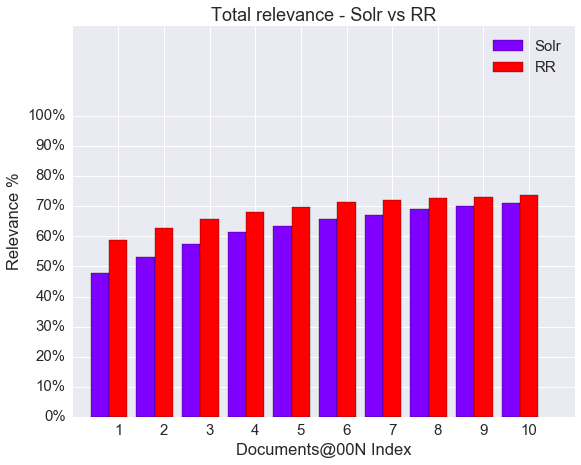

In [12]:
plot_total_relevance_at_n([solr_entries, rr_entries],
                          legend=['Solr','RR'],
                          title='Total relevance - Solr vs RR')

## Normalized Discounted Cumulative Gain (NDCG)

Discounted Cumulative Gain is an Information Retrieval Metric that takes into account the position and relevance of documents at different positions. Normalized Discounted Cumulative Gain normalizes the metric based on what the optimal ranking of results would be.

Notation:
rel_i = relevance of ith document

DCG@00N = rel_1 + sum(rel_i / log2(i + 1) for i in range(1,n))

NDCG@00N = DCG@00N / IDCG@00N

IDCG@00N = "DCG of the optimal ordering of a result set"

For example, consider a query that has 3 relevant documents. 1 of these 3 documents has relevance 2 and the other 2 have relevance 1, (and naturally all other documents have relevance 0). Assume the relevance of the documents in the result set is as follows

RS = [1, 0, 2, 1, 0, ...] (first retrieved document has relevance 1, second has relevance 0, etc.)

The optimal result set would have most relevant documents first. Here is the ideal ordering for this problem:
IRS = [2, 1, 1, 0, 0, ...]

After doing the math, we get:
DCG@005  = 2.43
IDCG@005 = 3.13
NDCG@005 = 0.77

In [13]:
absolute_strategy_ndcg = functools.partial(au.experiment_average_ndcg, method='absolute')
relative_strategy_ndcg = functools.partial(au.experiment_average_ndcg, method='relative')
plot_absolute_ndcg = functools.partial(au.plot_relevance_results, func=absolute_strategy_ndcg,
                                      xlabel='Documents@00N Index', ylabel='NDCG',
                                      title='Absolute NDCG@00N')
plot_relative_ndcg = functools.partial(au.plot_relevance_results, func=relative_strategy_ndcg,
                                        xlabel='Documents@00N Index', ylabel='NDCG',
                                        title='Relative NDCG@00N')

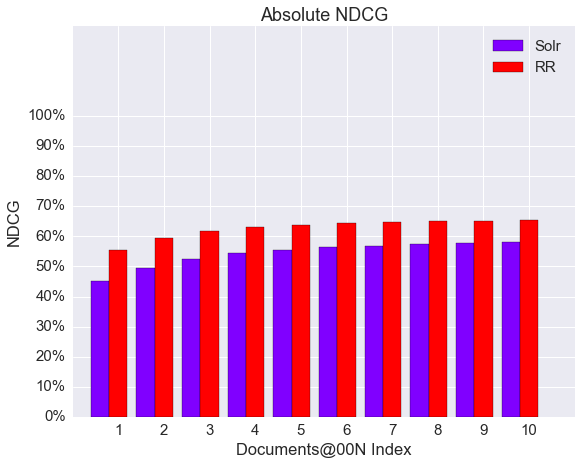

In [14]:
plot_absolute_ndcg([solr_entries, rr_entries],
                    legend=['Solr', 'RR'],
                    title='Absolute NDCG')

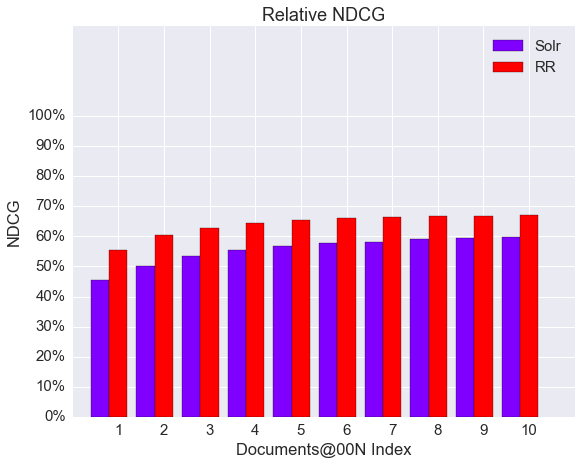

In [15]:
plot_relative_ndcg([solr_entries, rr_entries],
                    legend=['Solr', 'RR'],
                    title='Relative NDCG')

The next step is to improve the results of the ranking phase by customizing scorers. In order to do that, open the Notebook "Custom Scorer.ipynb" and follow the instructions.